# 1-D Inviscid Burgers Experiment: Reduced-Order Modeling

This notebook compares the methods of Active Subspaces, Active Manifolds, and local linear interpolation as reduced-order models for the solution of the parameterized 1-D Inviscid Burgers equation:

$$ \begin{align}\label{eq:mainsystem}
\begin{split}
    w_t + \frac{1}{2}\left(w^2\right)_x &= 0.02e^{\mu_2 x}, \\
    w(0, t, \boldsymbol{\mu}) &= \mu_1, \\
    w(x,0,\boldsymbol{\mu}) &= 1.
\end{split}
\end{align} $$

In particular, the aim is to train a model which approximates the solution $w$ at any point $(x,t,\boldsymbol\mu)$ without requiring a full numerical simulation of the PDE.

In [1]:
# Import packages and point to installation of burgers.py, numethod.py, and the AS module.
# (You will have to adjust this for your installation.)

# Path stuff
import sys
sys.path.insert(0, "/Users/anthonygruber/Desktop/Projects/AMv2/src")

# Standard packages
import numpy as np
import scipy as sy
import matplotlib.pyplot as plt

# For 3D plots
from mpl_toolkits import mplot3d

# Handwritten code
import numethod as nm
import burgers as bg
import active_subspaces as ac

### Preprocessing the data.

Preprocessing the data in this case is significantly more involved.  Note that $w$ is "u" in the code.

In [2]:
# Because this code is still running Python 2...
from __future__ import division

# Initial mesh data
points = [0, 0, 0, 0, 0, 0, 0]
np.random.seed(0) # for reproducibility
points[6] = np.random.uniform( -1, 1, (1000, 3) )
points[5] = np.random.uniform( -1, 1, (500, 3) )
points[4] = np.random.uniform( -1, 1, (200, 3) )
points[3] = np.random.uniform( -1, 1, (100, 3) )
points[2] = np.random.uniform( -1, 1, (50, 3) )
points[1] = np.random.uniform( -1, 1, (25, 3) )
points[0] = np.random.uniform( -1, 1, (10, 3) )

# Adjust simulation parameters -- a much coarser discretization works here
num = 4
numx = 50
numt = 100

# Upper and Lower bounds for parameters, taken from Carlberg paper
UBs = np.array( [45, 5.5, 0.03] )
LBs = np.array( [25, 4.25, 0.015] )

# Linear scaling to appropriate range
nuPoints = np.zeros_like(points)

for i in range(num):
  nuPoints[i] = LBs + 0.5 * (UBs - LBs) * (1 + points[i])

# Zero data vector
data = np.zeros_like(points)

# Compute PDE solution and derivatives. Note that the final time is 35 in every case.
for i in range(num):
  data[i] = list ( map( lambda x: bg.burgers( 2, numx, numt, 35, 1, nuPoints[i][x, 1:],
                                             False)[0], range( len(nuPoints[i]) ) ) )

# Define x and t points, same for every number of samples.
xx = np.linspace(0, 100, numx)
dx = (100-0) / numx
dt = 35 / numt
tt = np.array([dt * i for i in range(numt+1)])

# Compute points in (x, t, \mu) space.
pointz = np.zeros_like(points)

for i in range(num):
  pointz[i] = np.array( [ np.concatenate( [[xx[j], tt[k]], nuPoints[i][l, 1:]] )
                         for j in range(len(xx)) for k in range(len(tt)) 
                         for l in range(len(nuPoints[i])) ] )

# Initialize all the stuff we need: scaled points, function, derivatives, scaled derivatives
nuPointz = np.zeros_like(pointz)
u = np.zeros_like(points)
dudx = np.zeros_like(points)
dudt = np.zeros_like(points)
dudmu1 = np.zeros_like(points)
dudmu2 = np.zeros_like(points)
gradu = np.zeros_like(points)
nuGradu = np.zeros_like(points)

# Ranges for affine rescaling (just the inverse of the function before)
UBs = np.array( [100, 35, 5.5, 0.03], dtype=float )
LBs = np.array( [0, 0, 4.25, 0.015], dtype=float )

# Collection of necessary quantities.  Note the order of the "for" loops.
for i in range(num):
  nuPointz[i] = 2 / (UBs - LBs) * (pointz[i] - LBs) - 1  # Application of rescaling function

  u[i] = np.array( [ data[i][l][0][k][j] for j in range(len(xx)) for k in range(len(tt)) 
                    for l in range(len(points[i])) ] )  # Function value

  dudx[i] = np.array( [ data[i][l][4][k][j] for j in range(len(xx)) for k in range(len(tt))
                       for l in range(len(points[i])) ] )  # Derivative in x

  dudmu1[i] = np.array( [data[i][l][1][k][j] for j in range(len(xx)) for k in range(len(tt))
                         for l in range(len(points[i]))] )  # Derivative in mu1
    
  dudmu2[i] = np.array( [data[i][l][2][k][j] for j in range(len(xx)) for k in range(len(tt))
                         for l in range(len(points[i]))] )  # Derivative in mu2

  dudt[i] = np.array( [data[i][l][3][k][j] for j in range(len(xx)) for k in range(len(tt))
                       for l in range(len(points[i]))] )  # Derivative in t

  gradu[i] = np.array( [ [dudx[i][j], dudt[i][j], dudmu1[i][j], dudmu2[i][j]] 
                        for j in range(len(u[i])) ] )  # Gradient in (x, t, \mu)

  nuGradu[i] = 0.5 * (UBs - LBs) * gradu[i]  # Chain rule

### Comparing AS and AM as a reduced-order model for the PDE solution $w$.

Note that AS is practically unusable, but AM yields errors that are okay.

In [3]:
# Main routine comparing AM and AS -- now on PDE solution w.
# Fourth input to nm.subspEx gives dimension of AS -- this can be tweaked.
for i in range(num):
  print( 'The number of samples is %i' %len(points[i]) )
  nm.manifoldEx( nuPointz[i], u[i], nuGradu[i], 0.1,
                0.2, nm.get_random_init_pt(4, 0), 0, False )

  # Note the use of a polynomial approximation in this case.
  # (Radial basis approximation is so slow it's unusable)
  nm.subspEx( nuPointz[i], u[i], nuGradu[i], 3, 0, 0.2, False, True )
  print(" ")

The number of samples is 10
The Relative L1 Error is 0.374429%
The Relative L2 Error is 2.506393%
The dimension of the Active Subspace is 3
The R^2 value of the response surface is 0.7648
The Relative L1 Error is 18.106095%
The Relative L2 Error is 20.115800%
 
The number of samples is 25
The Relative L1 Error is 0.387577%
The Relative L2 Error is 2.636464%
The dimension of the Active Subspace is 3
The R^2 value of the response surface is 0.7515
The Relative L1 Error is 18.825991%
The Relative L2 Error is 20.984360%
 
The number of samples is 50
The Relative L1 Error is 0.375653%
The Relative L2 Error is 2.541951%
The dimension of the Active Subspace is 3
The R^2 value of the response surface is 0.7593
The Relative L1 Error is 18.487771%
The Relative L2 Error is 20.589389%
 
The number of samples is 100
The Relative L1 Error is 0.357118%
The Relative L2 Error is 2.469573%
The dimension of the Active Subspace is 3
The R^2 value of the response surface is 0.7542
The Relative L1 Error is 

## Visualization

A couple of different visualization options exist in this case.  

First, consider the standard comparison we have been using.

The Relative L1 Error is 0.386363%
The Relative L2 Error is 2.634754%


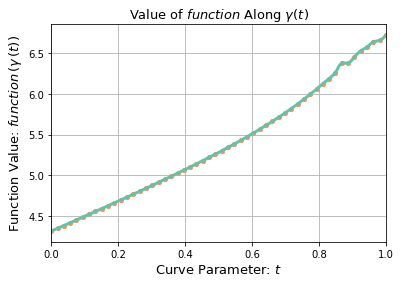

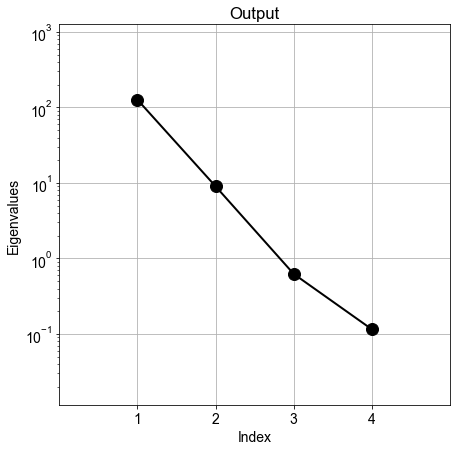

The dimension of the Active Subspace is 1
The R^2 value of the response surface is 0.6739
The Relative L1 Error is 21.660344%
The Relative L2 Error is 24.124797%


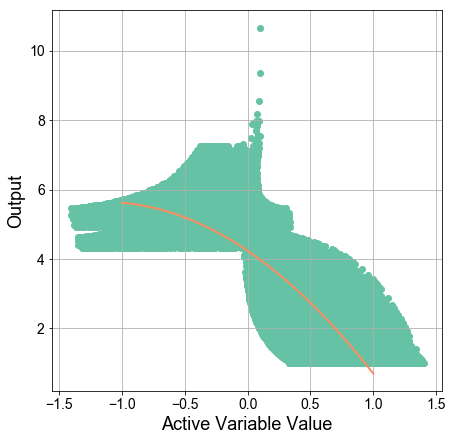

In [4]:
# Visualize the AM and AS for one set -- PDE solution w.
nm.manifoldEx( nuPointz[1], u[1], nuGradu[1], 0.05, 0.2, nm.get_random_init_pt(4, 0), 0 )
nm.subspEx( nuPointz[1], u[1], nuGradu[1], 1, 0, 0.2, True, True )

### Predicting a new solution 

On the other hand, since $w$ is actually the solution to Burgers' equation, 
 we can test the ability of our method to predict new solutions.
 
For comparison, we choose the parameter configurations in Lee and Carlberg.

In [5]:
# Choose some parameter configuration not in training set.
# Assemble points where solution values are needed.
test1 = np.array( [ np.concatenate( [[xx[j], tt[k]], [4.3, 0.021]] ) 
                  for k in range(len(tt)) for j in range(len(xx)) ] )

test2 = np.array( [ np.concatenate( [[xx[j], tt[k]], [5.15, 0.0285]] ) 
                  for k in range(len(tt)) for j in range(len(xx)) ] )

# Map inputs to [-1,1]^4
nuTest1 = 2 / (UBs - LBs) * (test1 - LBs) - 1
nuTest2 = 2 / (UBs - LBs) * (test2 - LBs) - 1

# Build a KD-tree corresponding to the training points.
tree = sy.spatial.KDTree(nuPointz[1], 1000)

vals1 = [0,0,0,0]
vals2 = [0,0,0,0]

for i in range(4):
  idx = int(numx / 10 * numt)
  vals1[i] = np.array( [ nm.get_f_value( nuTest1[idx*(i+1) + j],
                      tree, u[1], nuGradu[1] ) for j in range(numx) ] )
  
  vals2[i] = np.array( [ nm.get_f_value( nuTest2[idx*(i+1) + j],
                      tree, u[1], nuGradu[1] ) for j in range(numx) ] )


### Visualizing the predicted solution

Plots of the predicted PDE solutions.  Times pictured are $t = 3.5, 7, 10.5, 14$.

First, we use 25 training parameter instances, much less than the Lee-Carlberg choice of 80.

The solution is not bad in most places, but not that great.

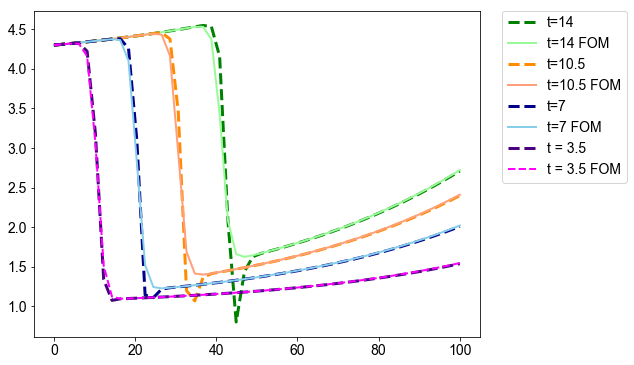

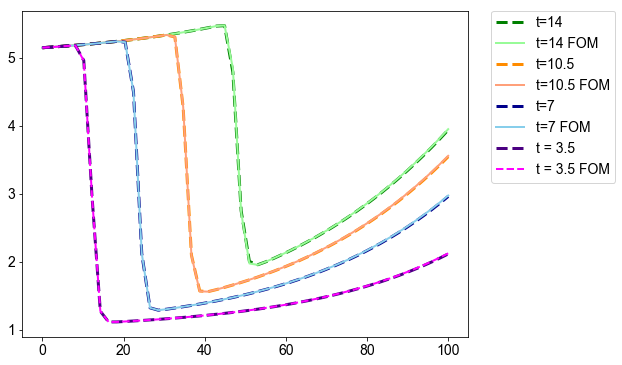

In [6]:
U1 = bg.burgers( 2, numx, numt, 35, 1, [4.3, 0.021], False)[0]
U2 = bg.burgers( 2, numx, numt, 35, 1, [5.15, 0.0285], False)[0]

ii = [int(0.1 * numt * (j+1)) for j in range(4)]

fig1 = plt.figure(figsize = (8, 6))
ax = fig1.add_subplot(111, label = 'first')
plt.plot(test1[0:numx][:,0], vals1[3], '--', c='green', label = 't=14', markersize=3, linewidth=3)
plt.plot(test1[0:numx][:,0], U1[0][ii[3]], '-', c='palegreen', label = 't=14 FOM', markersize=2, linewidth=2 )
plt.plot(test1[0:numx][:,0], vals1[2], '--', c='darkorange', label = 't=10.5', markersize=3, linewidth=3)
plt.plot(test1[0:numx][:,0], U1[0][ii[2]], '-', c='lightsalmon', label = 't=10.5 FOM', markersize=2, linewidth=2)
plt.plot(test1[0:numx][:,0], vals1[1], '--', c='darkblue', label = 't=7', markersize=3, linewidth=3)
plt.plot(test1[0:numx][:,0], U1[0][ii[1]], '-', c='skyblue', label = 't=7 FOM', markersize=2, linewidth=2)
plt.plot(test1[0:numx][:,0], vals1[0], '--', c='indigo', label = 't = 3.5', markersize=3, linewidth=3)
plt.plot(test1[0:numx][:,0], U1[0][ii[0]], '--', c='magenta', label = 't = 3.5 FOM', markersize=2, linewidth=2)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

fig2 = plt.figure(figsize = (8, 6))
ax = fig2.add_subplot(111, label = 'second')
plt.plot(test2[0:numx][:,0], vals2[3], '--', c='green', label = 't=14', markersize=3, linewidth=3)
plt.plot(test2[0:numx][:,0], U2[0][ii[3]], '-', c='palegreen', label = 't=14 FOM', markersize=2, linewidth=2 )
plt.plot(test2[0:numx][:,0], vals2[2], '--', c='darkorange', label = 't=10.5', markersize=3, linewidth=3)
plt.plot(test2[0:numx][:,0], U2[0][ii[2]], '-', c='lightsalmon', label = 't=10.5 FOM', markersize=2, linewidth=2)
plt.plot(test2[0:numx][:,0], vals2[1], '--', c='darkblue', label = 't=7', markersize=3, linewidth=3)
plt.plot(test2[0:numx][:,0], U2[0][ii[1]], '-', c='skyblue', label = 't=7 FOM', markersize=2, linewidth=2)
plt.plot(test2[0:numx][:,0], vals2[0], '--', c='indigo', label = 't = 3.5', markersize=3, linewidth=3)
plt.plot(test2[0:numx][:,0], U2[0][ii[0]], '--', c='magenta', label = 't = 3.5 FOM', markersize=2, linewidth=2)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### With 100 training instances

Now the solution is good, at least for these parameters.

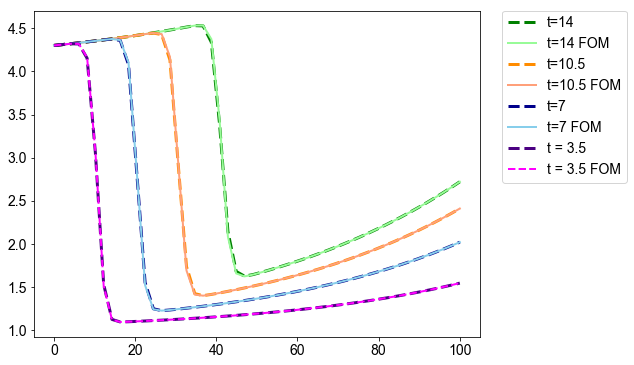

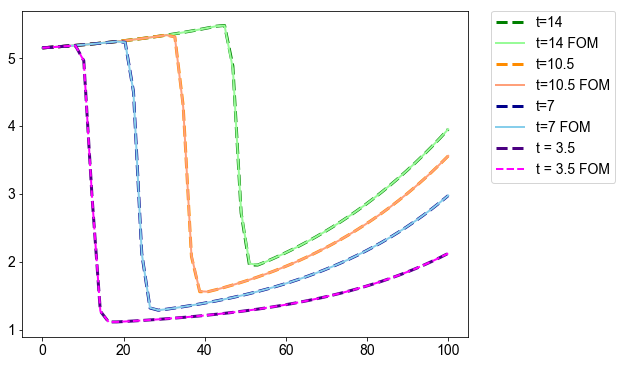

In [7]:
# Choose some parameter configuration not in training set.
# Assemble points where solution values are needed.
test1 = np.array( [ np.concatenate( [[xx[j], tt[k]], [4.3, 0.021]] ) 
                  for k in range(len(tt)) for j in range(len(xx)) ] )

test2 = np.array( [ np.concatenate( [[xx[j], tt[k]], [5.15, 0.0285]] ) 
                  for k in range(len(tt)) for j in range(len(xx)) ] )

# Map inputs to [-1,1]^4
nuTest1 = 2 / (UBs - LBs) * (test1 - LBs) - 1
nuTest2 = 2 / (UBs - LBs) * (test2 - LBs) - 1

# Build a KD-tree corresponding to the training points.
tree = sy.spatial.KDTree(nuPointz[3], 1000)

vals1 = [0,0,0,0]
vals2 = [0,0,0,0]

for i in range(4):
  idx = int(numx / 10 * numt)
  vals1[i] = np.array( [ nm.get_f_value( nuTest1[idx*(i+1) + j],
                      tree, u[3], nuGradu[3] ) for j in range(numx) ] )
  
  vals2[i] = np.array( [ nm.get_f_value( nuTest2[idx*(i+1) + j],
                      tree, u[3], nuGradu[3] ) for j in range(numx) ] )

    
fig1 = plt.figure(figsize = (8, 6))
ax = fig1.add_subplot(111, label = 'first')
plt.plot(test1[0:numx][:,0], vals1[3], '--', c='green', label = 't=14', markersize=3, linewidth=3)
plt.plot(test1[0:numx][:,0], U1[0][ii[3]], '-', c='palegreen', label = 't=14 FOM', markersize=2, linewidth=2 )
plt.plot(test1[0:numx][:,0], vals1[2], '--', c='darkorange', label = 't=10.5', markersize=3, linewidth=3)
plt.plot(test1[0:numx][:,0], U1[0][ii[2]], '-', c='lightsalmon', label = 't=10.5 FOM', markersize=2, linewidth=2)
plt.plot(test1[0:numx][:,0], vals1[1], '--', c='darkblue', label = 't=7', markersize=3, linewidth=3)
plt.plot(test1[0:numx][:,0], U1[0][ii[1]], '-', c='skyblue', label = 't=7 FOM', markersize=2, linewidth=2)
plt.plot(test1[0:numx][:,0], vals1[0], '--', c='indigo', label = 't = 3.5', markersize=3, linewidth=3)
plt.plot(test1[0:numx][:,0], U1[0][ii[0]], '--', c='magenta', label = 't = 3.5 FOM', markersize=2, linewidth=2)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

fig2 = plt.figure(figsize = (8, 6))
ax = fig2.add_subplot(111, label = 'second')
plt.plot(test2[0:numx][:,0], vals2[3], '--', c='green', label = 't=14', markersize=3, linewidth=3)
plt.plot(test2[0:numx][:,0], U2[0][ii[3]], '-', c='palegreen', label = 't=14 FOM', markersize=2, linewidth=2 )
plt.plot(test2[0:numx][:,0], vals2[2], '--', c='darkorange', label = 't=10.5', markersize=3, linewidth=3)
plt.plot(test2[0:numx][:,0], U2[0][ii[2]], '-', c='lightsalmon', label = 't=10.5 FOM', markersize=2, linewidth=2)
plt.plot(test2[0:numx][:,0], vals2[1], '--', c='darkblue', label = 't=7', markersize=3, linewidth=3)
plt.plot(test2[0:numx][:,0], U2[0][ii[1]], '-', c='skyblue', label = 't=7 FOM', markersize=2, linewidth=2)
plt.plot(test2[0:numx][:,0], vals2[0], '--', c='indigo', label = 't = 3.5', markersize=3, linewidth=3)
plt.plot(test2[0:numx][:,0], U2[0][ii[0]], '--', c='magenta', label = 't = 3.5 FOM', markersize=2, linewidth=2)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## Errors

Sadly, for fixed $x$ and $t$ the method seems to be still comparable to local linear interpolation in $\boldsymbol\mu$ for SOME instances of parameters.  In particular, given solutions $w(x,t,\boldsymbol\mu_1)$ and $w(x,t,\boldsymbol\mu_2)$, it is straightforward to define 

$$\hat w(x,t,s) = s\, w(x,t,\boldsymbol\mu_2) + (1-s)w(x,t,\boldsymbol\mu_1) \approx w(x,t, s\,\boldsymbol\mu_2 + (1-s)\boldsymbol\mu_1)$$

for $s\in[0,1]$.  For example:

Errors in AM approximation
The relative L1 error for t = 3.500000 is 0.138966
The relative L2 error for t = 3.500000 is 0.262656
The relative L1 error for t = 7.000000 is 0.172360
The relative L2 error for t = 7.000000 is 0.347649
The relative L1 error for t = 10.500000 is 0.174854
The relative L2 error for t = 10.500000 is 0.389805
The relative L1 error for t = 14.000000 is 0.172948
The relative L2 error for t = 14.000000 is 0.413512
The relative L1 error for t = 17.500000 is 0.134572
The relative L2 error for t = 17.500000 is 0.348977
The relative L1 error for t = 21.000000 is 0.103147
The relative L2 error for t = 21.000000 is 0.261283
 
Errors in local linear approximation
The relative L1 error for t = 3.500000 is 0.186443
The relative L2 error for t = 3.500000 is 0.238777
The relative L1 error for t = 7.000000 is 0.249563
The relative L2 error for t = 7.000000 is 0.316916
The relative L1 error for t = 10.500000 is 0.253980
The relative L2 error for t = 10.500000 is 0.334421
The re

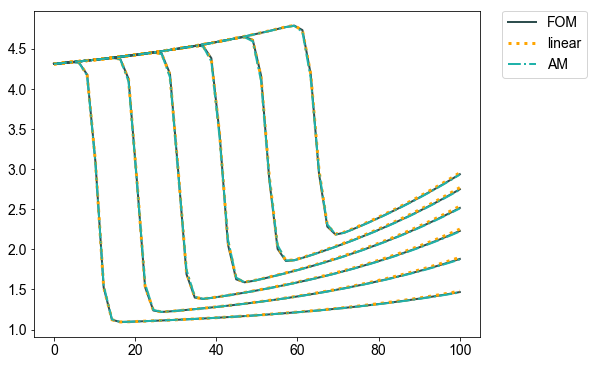

In [8]:
# Define some mu values (in training set) to interpolate between
mu1 = np.array([4.44798934e+00, 1.51335924e-02])
mu2 = np.array([5.10220733e+00, 2.06308383e-02])
mu3 = np.array([4.26925806e+00, 2.08011350e-02])

# This function tests the performance of AM against the linear interpolation formed from the exact solutions at mu_i
nm.test_local_linear(nuPointz[3], u[3], nuGradu[3], 50, 100, mu1, mu3, 0.75, 6)

### Conversely, sometimes it is much better or much worse than local linear interpolation.

See this example.  The simulation seems to be very sensitive...

the dist between mu1 and mu2 is 0.654241
the distance between mu1 and mu3 is 0.178821
 
Errors in AM approximation
The relative L1 error for t = 3.500000 is 0.010865
The relative L2 error for t = 3.500000 is 0.028565
The relative L1 error for t = 7.000000 is 0.021045
The relative L2 error for t = 7.000000 is 0.058973
The relative L1 error for t = 10.500000 is 0.023416
The relative L2 error for t = 10.500000 is 0.072819
The relative L1 error for t = 14.000000 is 0.036631
The relative L2 error for t = 14.000000 is 0.121238
The relative L1 error for t = 17.500000 is 0.045573
The relative L2 error for t = 17.500000 is 0.163320
The relative L1 error for t = 21.000000 is 0.068318
The relative L2 error for t = 21.000000 is 0.247676
 
Errors in local linear approximation
The relative L1 error for t = 3.500000 is 0.357258
The relative L2 error for t = 3.500000 is 0.789758
The relative L1 error for t = 7.000000 is 0.694559
The relative L2 error for t = 7.000000 is 1.633999
The relative L1 error 

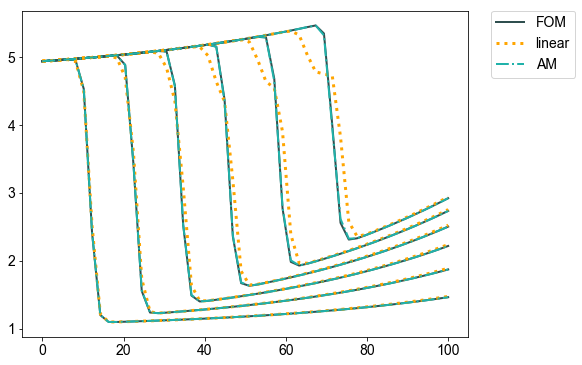

Errors in AM approximation
The relative L1 error for t = 3.500000 is 0.333746
The relative L2 error for t = 3.500000 is 0.809536
The relative L1 error for t = 7.000000 is 0.525392
The relative L2 error for t = 7.000000 is 1.357508
The relative L1 error for t = 10.500000 is 0.676127
The relative L2 error for t = 10.500000 is 1.880563
The relative L1 error for t = 14.000000 is 0.717334
The relative L2 error for t = 14.000000 is 2.243326
The relative L1 error for t = 17.500000 is 1.000744
The relative L2 error for t = 17.500000 is 3.089582
The relative L1 error for t = 21.000000 is 1.238615
The relative L2 error for t = 21.000000 is 3.908482
 
Errors in local linear approximation
The relative L1 error for t = 3.500000 is 0.241869
The relative L2 error for t = 3.500000 is 0.305997
The relative L1 error for t = 7.000000 is 0.326574
The relative L2 error for t = 7.000000 is 0.410404
The relative L1 error for t = 10.500000 is 0.334216
The relative L2 error for t = 10.500000 is 0.438494
The re

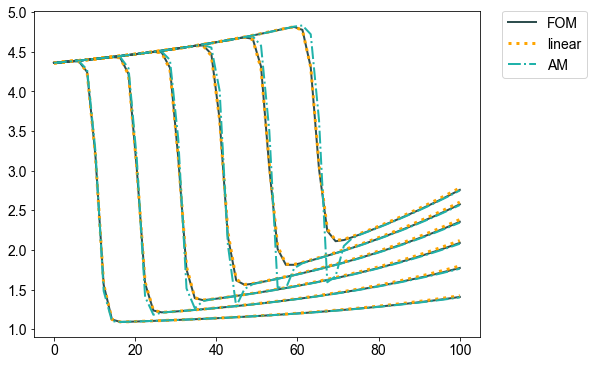

In [9]:
# It is worth mentioning that mu1 and mu3 are much closer than mu1 and mu2.
print('the dist between mu1 and mu2 is %2f' %(np.linalg.norm(mu2-mu1)))
print('the distance between mu1 and mu3 is %2f' %(np.linalg.norm(mu3-mu1)))
print(" ")

nm.test_local_linear(nuPointz[3], u[3], nuGradu[3], 50, 100, mu1, mu2, 0.75, 6)

nm.test_local_linear(nuPointz[3], u[3], nuGradu[3], 50, 100, mu1, mu3, 0.5, 6)